In [1]:
import hoomd
import hoomd.md
import numpy as np

In [2]:
# ------------------------ PARAMETERS ------------------------
n_stars_N1 = 600  # 7 A ends, 1 B end
n_stars_N2 = 300  # 1 A end, 7 B ends
segments_per_star = 25
total_stars = n_stars_N1 + n_stars_N2
total_segments = total_stars * segments_per_star
rho = 0.9233  # density
sigma = 0.9  # for WCA and LJ
epsilon = 1.0
dt = 0.001
kT = 0.0025

In [3]:
# ------------------------ INIT DEVICE ------------------------
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device, seed=42)

In [4]:
# ------------------------ GEOMETRY ------------------------
def random_pos(box_len):
    return np.random.uniform(-box_len / 2, box_len / 2, size=3)
# def create_star(center, arm_types, spacing=1.0, start_index=0):
#     positions = [center]
#     types = ['C']
#     bonds = []
#     index = start_index
#     directions = np.linspace(0, 2 * np.pi, 8, endpoint=False)

#     for i, angle in enumerate(directions):
#         vec = np.array([np.cos(angle), np.sin(angle), 0])
#         prev_idx = index  # center index
#         for j in range(1, 4):
#             pos = center + j * spacing * vec
#             positions.append(pos)
#             current_idx = index + j
#             bonds.append([prev_idx, current_idx])
#             prev_idx = current_idx
#             types.append('A' if j == 3 else 'M')

#         types[-1] = arm_types[i]  # set last as A or B
#         index += 3

#     return positions, types, bonds

def wrap_into_box(pos, box_lengths):
    """
    Wrap a particle position into the periodic box.

    Parameters
    ----------
    pos : array-like, shape (3,)
        The [x, y, z] position in Cartesian coordinates.
    box_lengths : array-like, shape (3,)
        The box dimensions [Lx, Ly, Lz].

    Returns
    -------
    wrapped_pos : ndarray, shape (3,)
        Position wrapped into the box, in range [-L/2, L/2).
    """
    pos = np.array(pos, dtype=float)
    L = np.array(box_lengths, dtype=float)
    wrapped_pos = ((pos + 0.5 * L) % L) - 0.5 * L
    return wrapped_pos

def create_star(center, arm_types, spacing=1.0, start_index=0):
    positions = [center]
    types = ['C']
    bonds = []
    
    central_idx = start_index  # This will be index 0 in this star
    current_idx = start_index + 1  # Next available index after center

    # Generate 8 directions roughly evenly spaced on a sphere
    golden_angle = np.pi * (3 - np.sqrt(5))
    directions = []
    for i in range(8):
        y = 1 - (i / 7.0) * 2  # y from 1 to -1
        radius = np.sqrt(1 - y * y)
        theta = golden_angle * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        directions.append(np.array([x, y, z]))

    for i, vec in enumerate(directions):
        prev = central_idx  # start from the center

        for j in range(3):  # 3 beads per arm
            pos = center + (j + 1) * spacing * vec
            positions.append(pos)

            bond = [prev, current_idx]
            bonds.append(bond)

            if j == 2:
                types.append(arm_types[i])  # Final bead is A or B
            else:
                types.append('M')

            prev = current_idx
            current_idx += 1

    return positions, types, bonds

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Example: test one star
center = random_pos(2)
arms = ['A'] * 7 + ['B']
np.random.shuffle(arms)

positions, types, bonds = create_star(center, arms)
positions = np.array(positions)


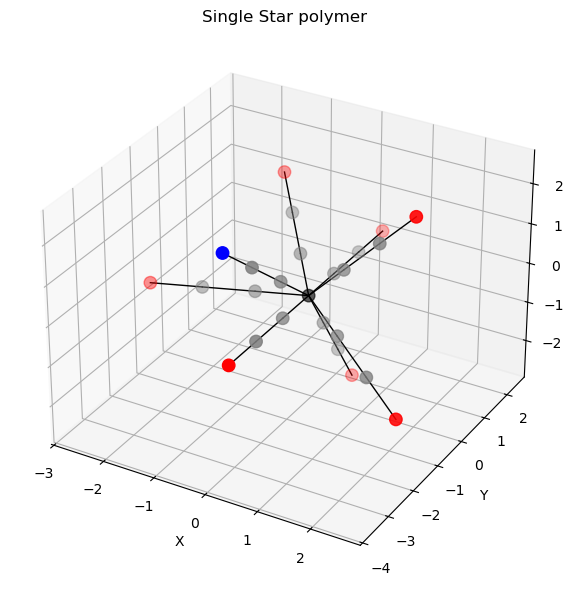

In [6]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Color map by type
color_map = {'C': 'black', 'M': 'gray', 'A': 'red', 'B': 'blue'}
colors = [color_map[t] for t in types]

# Plot beads
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=colors, s=80)

# Plot bonds
for i, j in bonds:
    x = [positions[i][0], positions[j][0]]
    y = [positions[i][1], positions[j][1]]
    z = [positions[i][2], positions[j][2]]
    ax.plot(x, y, z, 'k-', linewidth=1)

ax.set_title('Single Star polymer')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()


In [7]:
# ------------------------ SYSTEM BUILD ------------------------
box_length = (total_segments / rho) ** (1 / 3)
all_pos, all_types, all_bonds = [], [], []
index_offset = 0

for _ in range(n_stars_N1):
    arms = ['A'] * 7 + ['B']
    np.random.shuffle(arms)
    pos, types, bonds = create_star(random_pos(box_length), arms, start_index=index_offset)
    all_pos.extend(pos)
    all_types.extend(types)
    all_bonds.extend(bonds)
    index_offset += len(pos)

for _ in range(n_stars_N2):
    arms = ['B'] * 7 + ['A']
    np.random.shuffle(arms)
    pos, types, bonds = create_star(random_pos(box_length), arms, start_index=index_offset)
    all_pos.extend(pos)
    all_types.extend(types)
    all_bonds.extend(bonds)
    index_offset += len(pos)

for i in range(len(all_pos)):
    all_pos[i] = wrap_into_box(all_pos[i],box_length)


In [8]:
all_pos[1]

array([13.31714175,  9.93416522, -2.56145051])

In [9]:
# ------------------------ SNAPSHOT ------------------------
snapshot = hoomd.Snapshot()
snapshot.particles.N = len(all_pos)
snapshot.particles.position[:] = all_pos
snapshot.particles.types = ['C', 'M', 'A', 'B']
snapshot.particles.typeid[:] = [snapshot.particles.types.index(t) for t in all_types]
snapshot.bonds.N = len(all_bonds)
snapshot.bonds.types = ['NN']
snapshot.bonds.group[:] = all_bonds
snapshot.bonds.typeid[:] = [0] * len(all_bonds)
snapshot.configuration.box = [box_length, box_length, box_length, 0, 0, 0]
sim.create_state_from_snapshot(snapshot)

In [10]:
# ------------------------ BONDED FORCE ------------------------
bond = hoomd.md.bond.Harmonic()
bond.params['NN'] = dict(k=100.0*kT, r0=1.0)
sim.operations.integrator = hoomd.md.Integrator(dt=dt)
sim.operations.integrator.forces.append(bond)

# ------------------------ WCA PAIR FORCE ------------------------
nl = hoomd.md.nlist.Cell(buffer=0.4)
nl.exclusions = ["bond"]
lj = hoomd.md.pair.LJ(nlist=nl)
lj.mode = 'shift'

wca_cut = 2 ** (1 / 6) * sigma
all_types = ['C', 'M', 'A', 'B']
for t1 in all_types:
    for t2 in all_types:
        # if set((t1, t2)) != set(('A', 'B')):
        lj.params[(t1, t2)] = dict(epsilon=kT, sigma=0.9)
        lj.r_cut[(t1, t2)] = wca_cut
#lj.r_cut[('A', 'B')] = 0  # disable A-B in LJ
#sim.operations.integrator.forces.append(lj)

# ------------------------ Soft repulsive force to initialize ------------------------

gauss = hoomd.md.pair.Gaussian(nlist=nl)

# Example: all particles interact softly at the start
for a in ['C', 'M', 'A', 'B']:
    for b in ['C', 'M', 'A', 'B']:
        gauss.params[(a,b)] = dict(epsilon=1.0, sigma=0.8)
        gauss.r_cut[(a,b)] = 3*0.8

sim.operations.integrator.forces.append(gauss)

In [11]:
# ------------------------ NVT THERMOSTAT ------------------------
mttk = hoomd.md.methods.thermostats.MTTK(
    kT=kT,
    tau=1.0,
)

nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=mttk
)
sim.operations.integrator.methods.append(nvt)
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)


In [12]:
# ------------------------ LOGGING AND RUN ------------------------
logger = hoomd.logging.Logger()
logger.add(sim, quantities=["timestep", "tps"])

gsd_writer = hoomd.write.GSD(
    filename="test_trajectory.gsd",
    trigger=hoomd.trigger.Periodic(10000),
    mode="wb",
    filter=hoomd.filter.All()
)
sim.operations.writers.append(gsd_writer)

sim.run(100000)

In [13]:
sim.operations.integrator.forces.remove(gauss)

In [14]:
sim.operations.integrator.forces.append(lj)

In [15]:
# ------------------------ REVERSIBLE CROSSLINKING ------------------------
rev_cross = hoomd.md.many_body.RevCross(default_r_cut=1.25,nlist=nl)
for t1 in all_types:
    for t2 in all_types:
        if set((t1, t2)) != set(('A', 'B')):
            rev_cross.params[(t1, t2)] = {"sigma":0,"n": 0, "epsilon": 0, "lambda3": 0}
rev_cross.params[('A','B')] = {
    "sigma": 0.5, "n": 10, "epsilon": kT, "lambda3": 1}
rev_cross.lambda_ = 1.0  # swap barrier control
rev_cross.epsilon = epsilon
sim.operations.integrator.forces.append(rev_cross)

In [16]:
sim.operations.writers.remove(gsd_writer)

In [17]:
# ------------------------ LOGGING AND RUN ------------------------
logger = hoomd.logging.Logger()
logger.add(sim, quantities=["timestep", "tps"])

gsd_writer = hoomd.write.GSD(
    filename="test_trajectory_wca.gsd",
    trigger=hoomd.trigger.Periodic(100),
    mode="wb",
    filter=hoomd.filter.All()
)
sim.operations.writers.append(gsd_writer)

sim.run(10000)

In [26]:
sim.run(1000)

In [27]:
11*20000/3600

61.111111111111114

In [22]:
def base_log_steps(duration, per_decade=20, include_end=True):
    """
    Return integer steps in [1, duration] spaced by Δlog10 = 1/per_decade.
    Example: per_decade=20 -> 20 intervals per decade (0.05 in log10).
    """
    if duration < 1:
        return np.array([], dtype=int)

    # quantize log10 to exact multiples of 1/per_decade
    qmin = 0                       # log10(1) = 0
    qmax = int(np.floor(np.log10(duration) * per_decade))
    if include_end:
        qmax += 1                  # include the upper boundary gridpoint

    grid = (np.arange(qmin, qmax) / per_decade)
    steps = np.rint(10.0**grid).astype(int)
    steps = steps[(steps >= 1) & (steps <= duration)]
    return np.unique(steps)

def steps_for_file(wait, base_steps, end=None):
    """
    Shift base_steps by 'wait'. If end is given, keep steps <= end.
    """
    s = wait + base_steps
    if end is not None:
        s = s[s <= end]
    return s


def write_logspaced_multiple(sim, files, base_steps):
    """
    files: list of dicts with {"filename":..., "wait":..., "end": optional}
    base_steps: 1D array of positive ints (the same for all files)
    """
    # Build step -> list of filenames map
    step_to_files = {}
    for f in files:
        fname = f["filename"]
        wait  = int(f["wait"])
        end   = f.get("end", None)
        file_steps = steps_for_file(wait+sim.timestep, base_steps, end=end)
        for s in file_steps:
            step_to_files.setdefault(int(s), []).append(fname)

    # Run the sim and write exactly at those steps
    current = int(sim.timestep)
    for target in sorted(step_to_files.keys()):
        if target > current:
            sim.run(target - current)
            current = target
        else: continue

        writers = []
        for fname in step_to_files[target]:
            w = hoomd.write.GSD(
                filename=fname,
                trigger=hoomd.trigger.Periodic(1),  # write next step only
                mode="ab",
                filter=hoomd.filter.All(),
            )
            sim.operations.writers.append(w)
            writers.append(w)

        sim.run(1)  # write
        current += 1

        for w in writers:
            sim.operations.writers.remove(w)

In [29]:
def tag(x, n): return f"{x:.{n}f}"
def fname(wait): return f"traj_T{tag(kT,3)}_rho{tag(rho,2)}_wait{wait}.gsd"

duration_after_wait = 1_000_0             # how long you want to sample after each wait
base = base_log_steps(duration_after_wait, per_decade=20, include_end=True)

files = [
    {"filename": fname(0),        "wait": 0,        "end": None},
    {"filename": fname(1000),  "wait": 1000,  "end": None},
    {"filename": fname(3000),  "wait": 2000,  "end": None},  # optional per-file cap
]

write_logspaced_multiple(sim, files, base)

In [28]:
def fname(wait): return f"traj_T{tag(kT,8)}_rho{tag(rho,6)}_wait{wait}.gsd"
fname(1000)

'traj_T0.00250000_rho0.923300_wait1000.gsd'

In [ ]:
# ------------------ Example usage ------------------
# Make sure sim.state is already created and integrator/methods/forces are set.

schedules = [
    {"filename": "early_wait.gsd", "wait": 0,       "end": 10000, "n": 40},   # starts immediately
    {"filename": "mid_wait.gsd",   "wait": 1000, "end": 10000, "n": 30},   # starts after 1e5 steps
    {"filename": "late_wait.gsd",  "wait": 3000, "end": 20000, "n": 30},   # starts even later
]

write_log_spaced_to_multiple_files(sim, schedules)

# If you want to keep running beyond the last logged frame:
sim.run(500_000)